## Imports

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os
from statsmodels.tsa.seasonal import seasonal_decompose
# from sklearn import datasets, svm, preprocessing
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_absolute_error, classification_report
# from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

## Data loading

In [90]:
df = pd.read_csv(os.getcwd()+"/pre_processing/dataset_traite.csv", sep=',', parse_dates=["DateTime"],index_col=['DateTime'])

In [91]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [93]:
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.050655e+00,1.120142e-01,3.219643e+00,4.416490e+00,6.114397e+00,5.785470e+00,8.384178e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.100000e-01,4.800000e-02,2.390200e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.300000e-01,1.020000e-01,2.409600e+02,2.800000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.520000e+00,1.920000e-01,2.428600e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


# Data Visualization

## Visualization of all our variables per day, month and year

##### mean value of all 7 variables per month

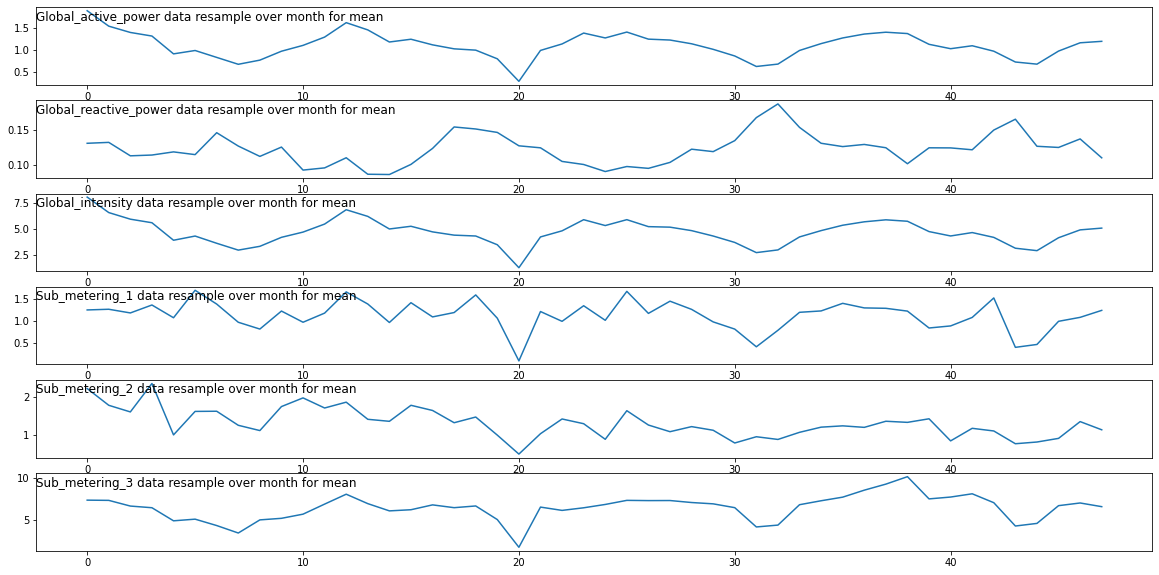

In [94]:
data = df.copy()
i = 1
cols=[0, 1, 3, 4, 5, 6]
plt.figure(figsize=(20, 10))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(data.resample('m').mean().values[:, col])
    plt.title(data.columns[col] + ' data resample over month for mean', y=0.75, loc='left')
    i += 1
plt.show()

##### all 7 variables per month (in one plot, scaled)

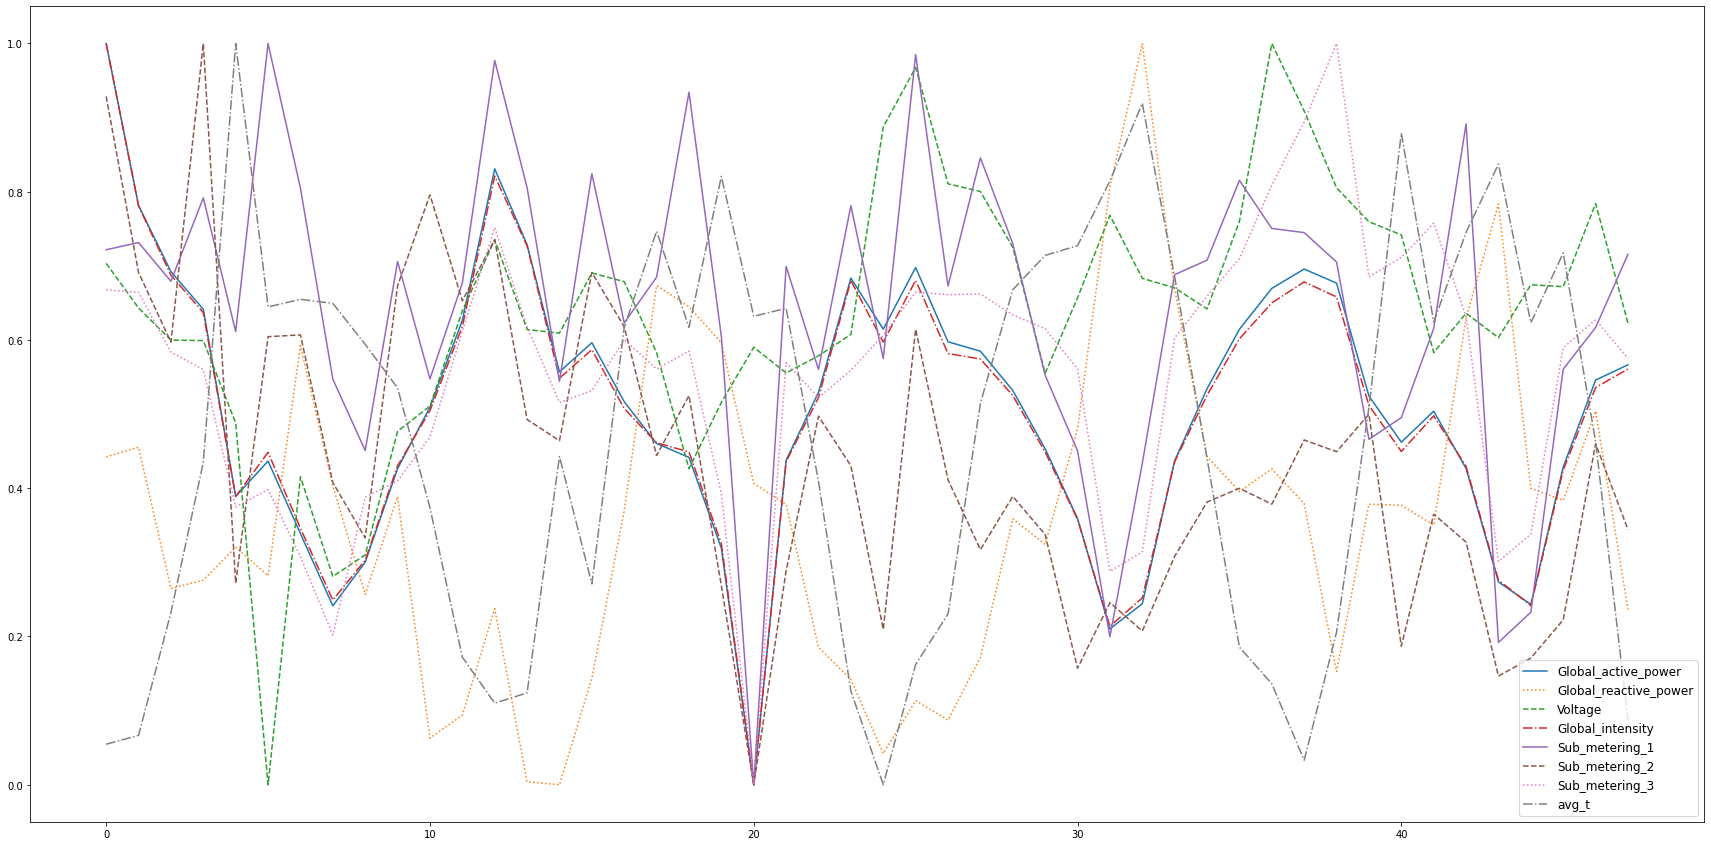

In [95]:
#plot global et sub sur meme plot, remettre a echelle

linestyle_str = ['solid','dotted','dashed','-.','-','--',':','dashdot']

data = df.copy()
data['Date'] = pd.to_datetime(data.index.date)
temperatures = pd.read_csv("pre_processing/temperatures.csv", parse_dates=['Date'], index_col='Date')
temperatures['avg_t'] = (temperatures['max_t'] - temperatures['min_t'])/2
data = data.join(temperatures, how="left", on='Date')
data = data.drop(columns=['Date','max_t','min_t'])
data = data.resample('m').mean()

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(data)
data[data.columns] = scaler.transform(data[data.columns])
plt.figure(figsize=(30, 15))
cols=[0, 1, 2, 3, 4, 5, 6, 7]
for col in cols:
    plt.plot(data.values[:, col],linestyle=linestyle_str[col])
plt.legend(data.columns,loc=4, bbox_to_anchor=(0.5, 0., 0.5, 0.5),fontsize="large")
plt.show()

##### Correlation matrix of all 7 variables

C:\Users\THEODL~1\AppData\Local\Temp/ipykernel_8804/1866267976.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


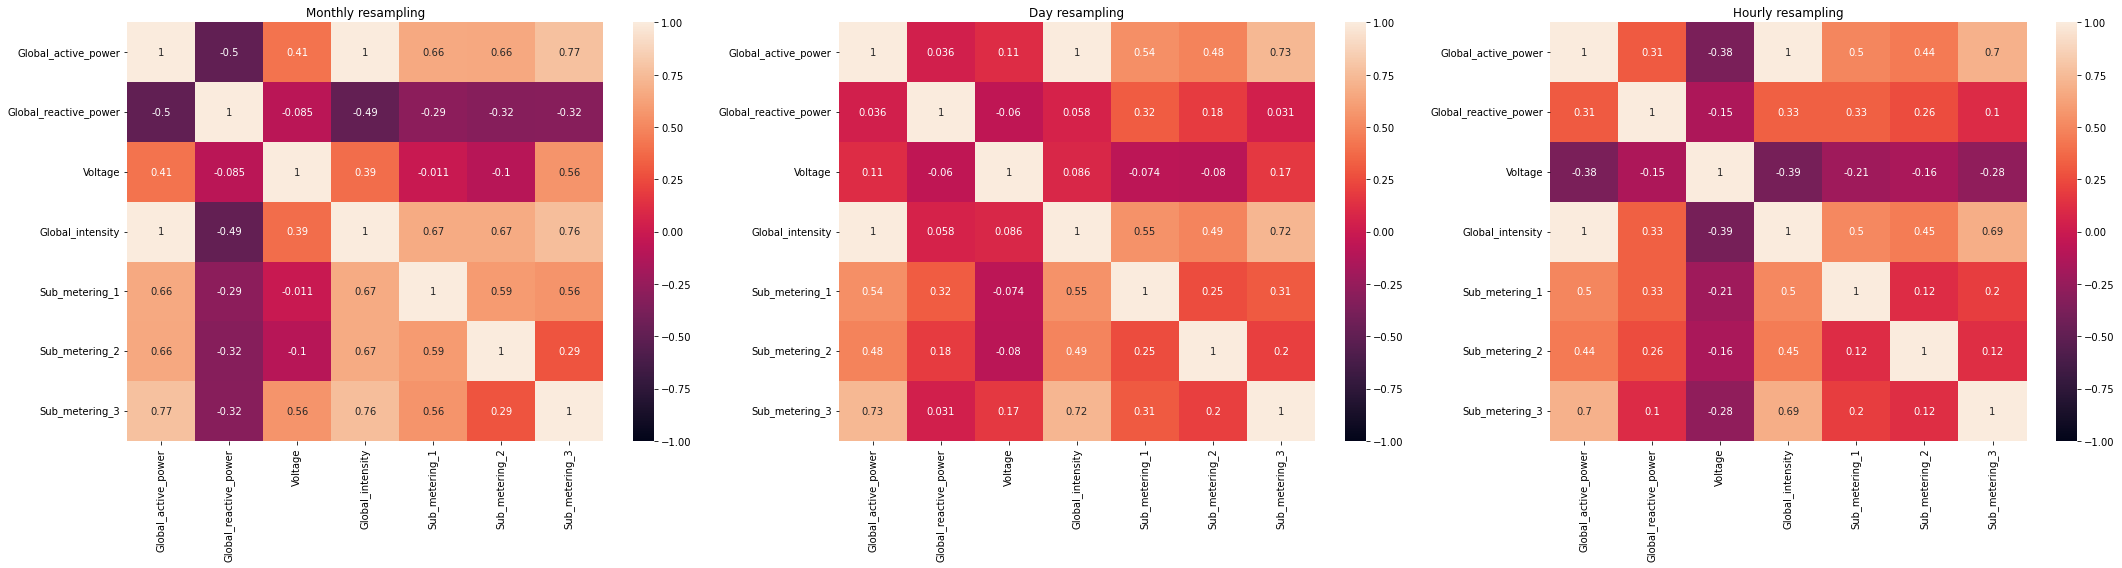

In [96]:
import seaborn as sns
fig,axs= plt.subplots(1,3,figsize=(30, 8))

dfm = df.resample('M').mean()
sns.heatmap(dfm.corr(), vmin=-1, vmax=1, annot=True, ax = axs[0])
axs[0].set_title('Monthly resampling', size=12)

dfd = df.resample('D').mean()
sns.heatmap(dfd.corr(), vmin=-1, vmax=1, annot=True, ax = axs[1])
axs[1].set_title('Day resampling', size=12)
  
dfh = df.resample('H').mean()
sns.heatmap(dfh.corr(), vmin=-1, vmax=1, annot=True, ax = axs[2])
axs[2].set_title('Hourly resampling', size=12)

fig.tight_layout()
fig.show()

##### distribution of the values of all 7 variables

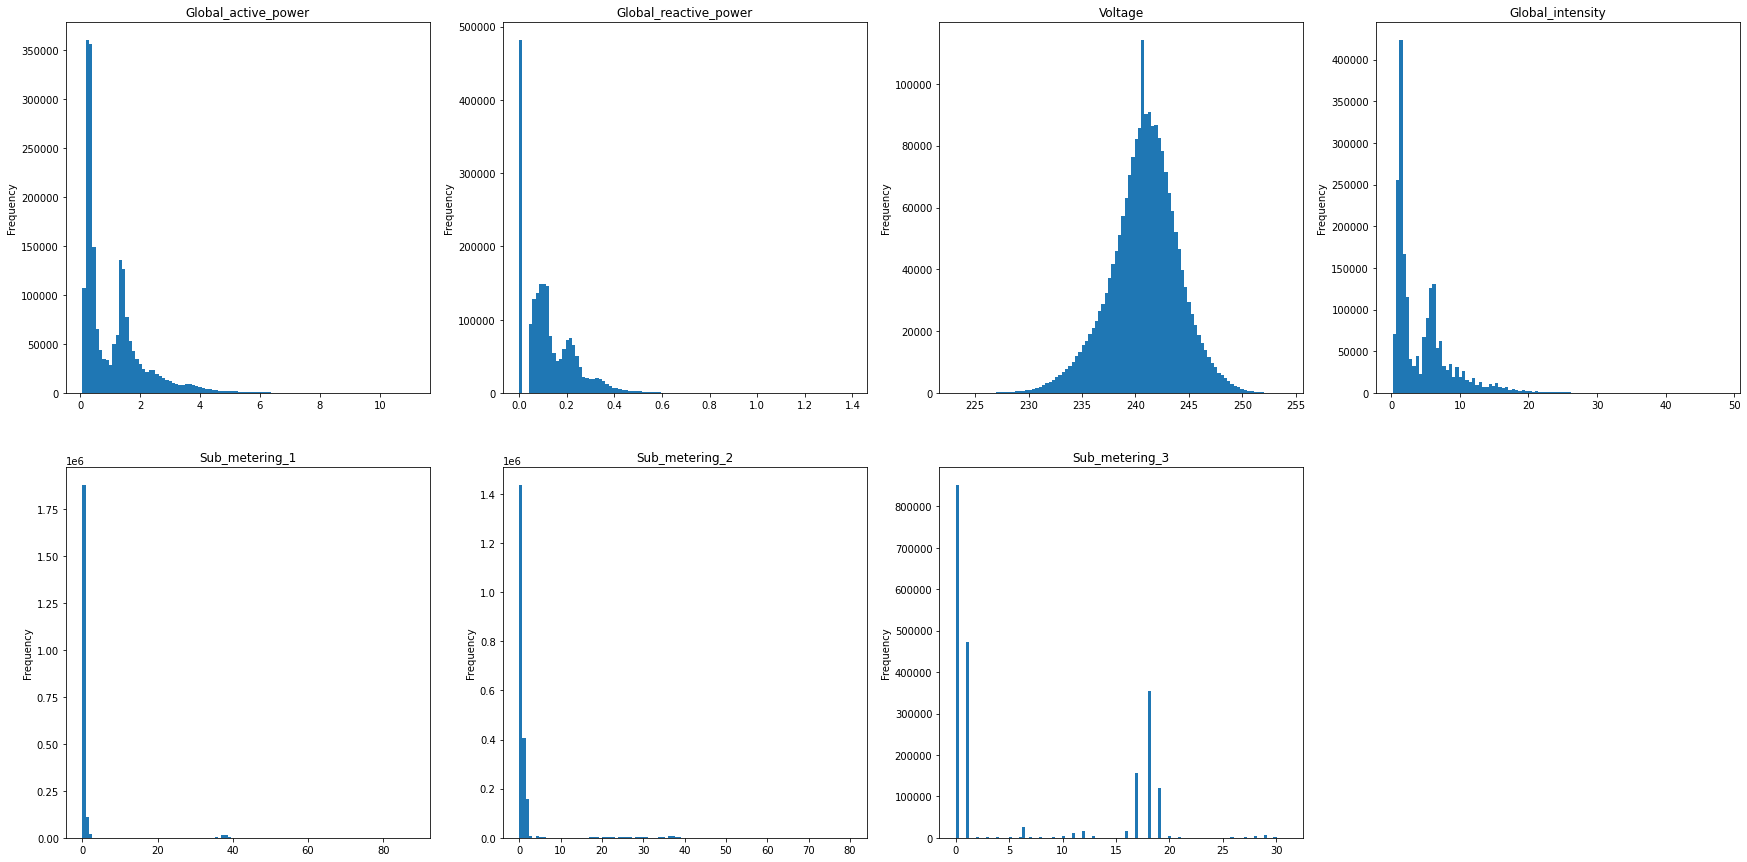

In [97]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(30,15))
fig.delaxes(axes[1,3])
for i in range(4):
    df[df.columns[i]].plot.hist(bins=100, alpha=1, ax=axes[0][i])
    axes[0][i].set_title(df.columns[i])
for i in range(4,7):
    df[df.columns[i]].plot.hist(bins=100, alpha=1, ax=axes[1][i-4])
    axes[1][i-4].set_title(df.columns[i])

### Visualization of Global_active_power (focus on 2007)

In [98]:
active_power_df = df[['Global_active_power']]
active_power_df = active_power_df.loc[active_power_df.index.year == 2007]

#### Average global active power (in kilowatt) per week in 2007

<AxesSubplot:title={'center':'Average global active power (in watt) per week in 2007'}, xlabel='DateTime'>

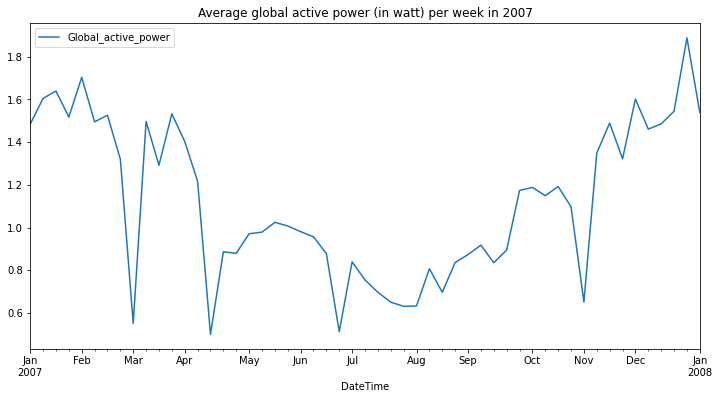

In [99]:
weekly_avg = active_power_df.resample("W").mean()
weekly_avg.plot(figsize=(12,6), title="Average global active power (in watt) per week in 2007")

#### Moving average of the daily average global active power (in watt) in 2007

<AxesSubplot:xlabel='DateTime'>

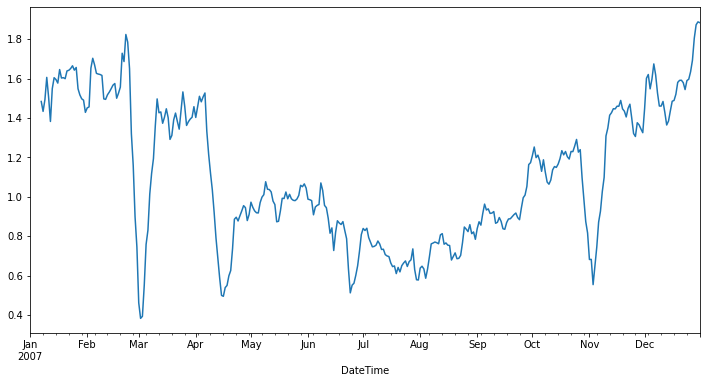

In [100]:
daily_avg = active_power_df.resample("D").mean()

sma_length = 7
sma = daily_avg["Global_active_power"].rolling(window=sma_length).mean()
sma.plot(figsize=(12,6))
# sma

### Visualization of Global_active_power for "Time Series Analysis"

In [113]:
from scipy import stats
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import pacf, plot_acf,plot_pacf
from pandas.plotting import autocorrelation_plot

##### Lag plot (resampled per week)

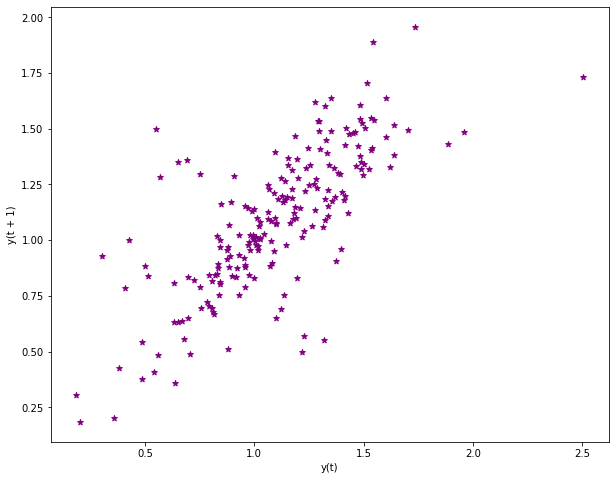

In [122]:
lagplot_data = df['Global_active_power'].resample('W').mean()
plt.figure(figsize = (10,8))
lagplot = lag_plot(lagplot_data, c = 'purple', marker = '*')
plt.show()

##### Correlation matrix of lagged variable

In [123]:
lagplot_data_df = pd.concat([lagplot_data.shift(-1), lagplot_data], axis = 1)
lagplot_data_df.columns = ['Global_active_power(t)', 'Global_active_power(t+1)']
lagplot_data_corr = lagplot_data_df.corr()
lagplot_data_corr

,Global_active_power(t),Global_active_power(t+1)
Global_active_power(t),1.000000,0.749457
Global_active_power(t+1),0.749457,1.000000


##### Autocorrelation plot 

In [124]:
df1 = df['Global_active_power'].resample('W').mean()
lagplot_data1 = df1.copy()

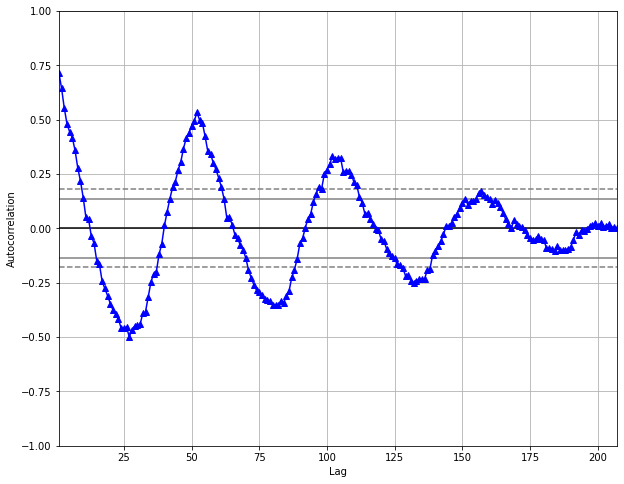

In [125]:
plt.figure(figsize = (10,8))
lagplot1 = autocorrelation_plot(lagplot_data1, c = 'blue', marker = '^')
lagplot1.plot(title = 'Autocorrelation Plot of the Data resampled over Hour')
plt.show()

##### ACF and PACF plot 

C:\Users\Theo dlz\data_analysis_env\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


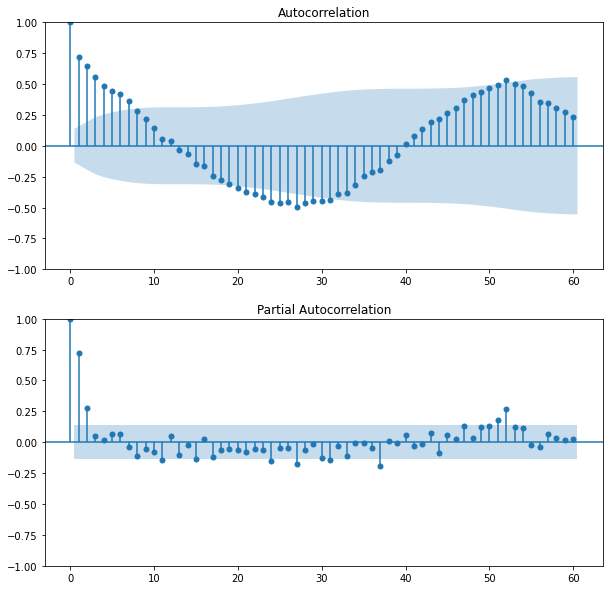

In [119]:
plt.figure(figsize = (10,10))
lags = 60
# acf
axis = plt.subplot(2, 1, 1)
plot_acf(df1, ax=axis, lags=lags)
# pacf
axis = plt.subplot(2, 1, 2)
plot_pacf(df1, ax=axis, lags=lags)
# show plot
plt.show()

##### Seasonality and Trend of the variable

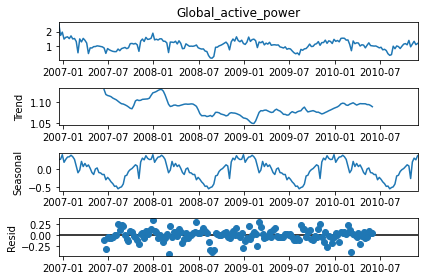

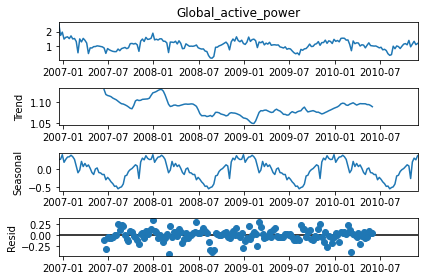

In [111]:
data2 = df.copy()
data2 = data2.resample('W').mean()
data2.fillna(data2.mean(), inplace=True)
seasonal_decompose(data2["Global_active_power"]).plot()

## Visualization of variables composing Global_active_power : sub_meterings

### Sub metering 1 (kitchen) per hour of the day

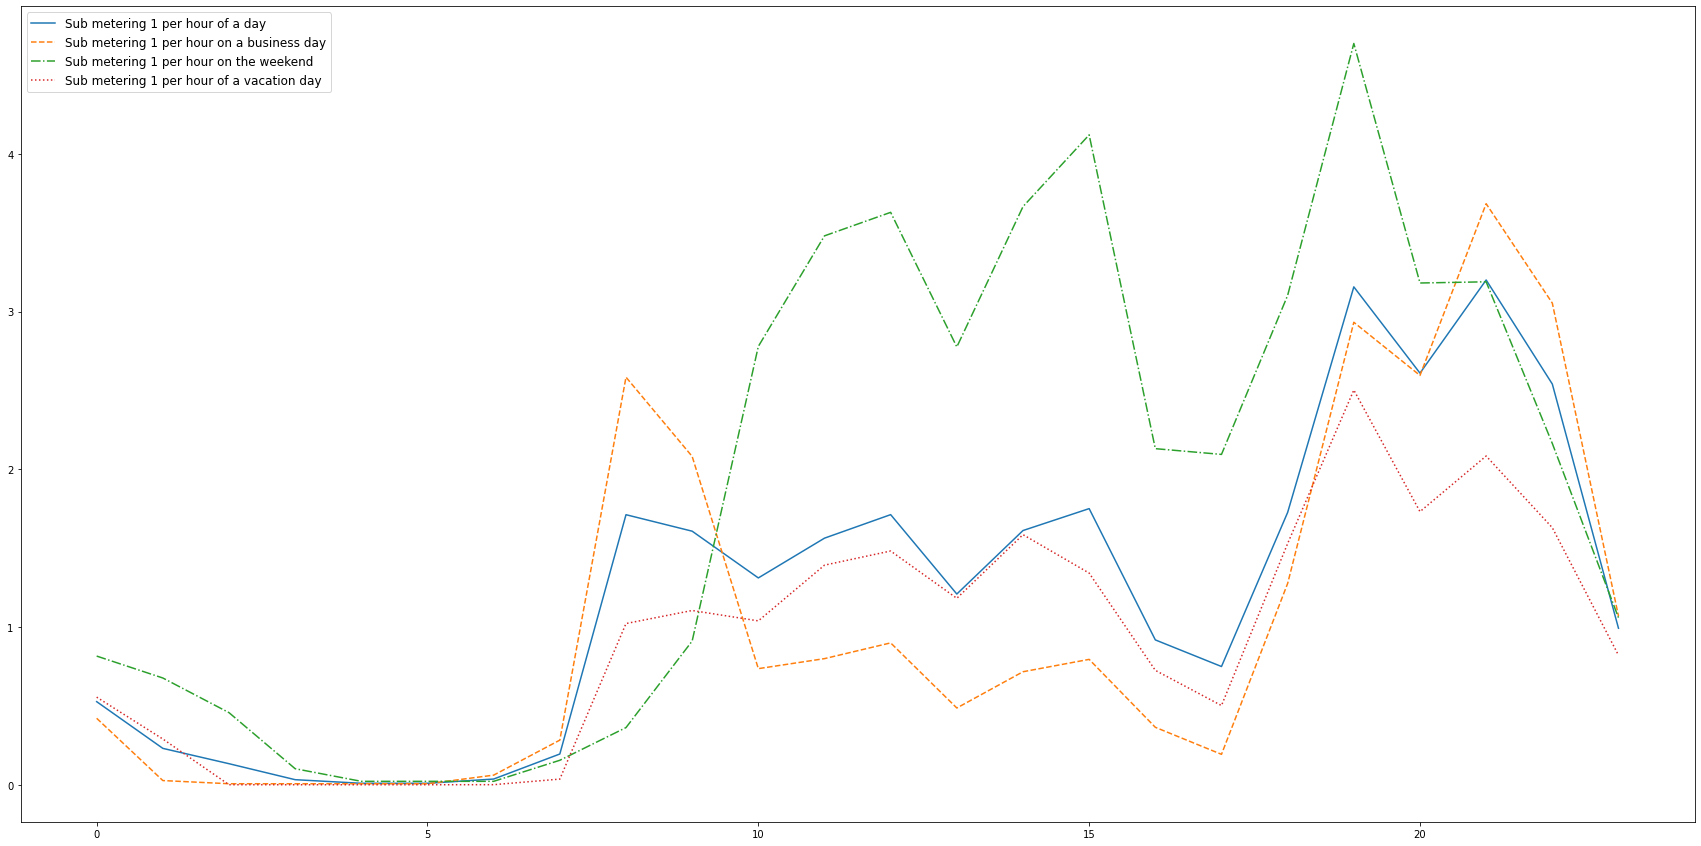

In [102]:
from vacances_scolaires_france import SchoolHolidayDates
import datetime
curves = ["Sub metering 1 per hour of a day","Sub metering 1 per hour on a business day","Sub metering 1 per hour on the weekend","Sub metering 1 per hour of a vacation day"]
d = SchoolHolidayDates()
dict_holidays = d.holidays_for_year_and_zone(2007, 'C')
holidays = dict_holidays.keys()

plt.figure(figsize=(30, 15))

sub1_df = df[['Sub_metering_1']]
sub1_df = sub1_df.reset_index()

sub1_df_all = sub1_df.loc[sub1_df["DateTime"].dt.year == 2007]
sub1_df_all.set_index('DateTime', inplace=True)
plt.plot(sub1_df_all.groupby(sub1_df_all.index.hour)["Sub_metering_1"].mean(),linestyle='-')

sub1_df_bd = sub1_df.loc[(sub1_df["DateTime"].dt.year == 2007) & (sub1_df["DateTime"].dt.weekday != 5) & (sub1_df["DateTime"].dt.weekday != 6) & (sub1_df["DateTime"].dt.date.isin(holidays)==False)]
sub1_df_bd.set_index('DateTime', inplace=True)
plt.plot(sub1_df_bd.groupby(sub1_df_bd.index.hour)["Sub_metering_1"].mean(),linestyle='--')

sub1_df_we = sub1_df.loc[(sub1_df["DateTime"].dt.year == 2007) & (sub1_df["DateTime"].dt.weekday.isin([5,6]))]
sub1_df_we.set_index('DateTime', inplace=True)
plt.plot(sub1_df_we.groupby(sub1_df_we.index.hour)["Sub_metering_1"].mean(),linestyle='-.')

sub1_df_hd = sub1_df.loc[(sub1_df["DateTime"].dt.year == 2007) & (sub1_df["DateTime"].dt.date.isin(holidays))]
sub1_df_hd.set_index('DateTime', inplace=True)
plt.plot(sub1_df_hd.groupby(sub1_df_hd.index.hour)["Sub_metering_1"].mean(),linestyle=':')

plt.legend(curves,loc=2,fontsize="large")

plt.show()

# add curves

### Sub metering 1 (kitchen) per minute of the day

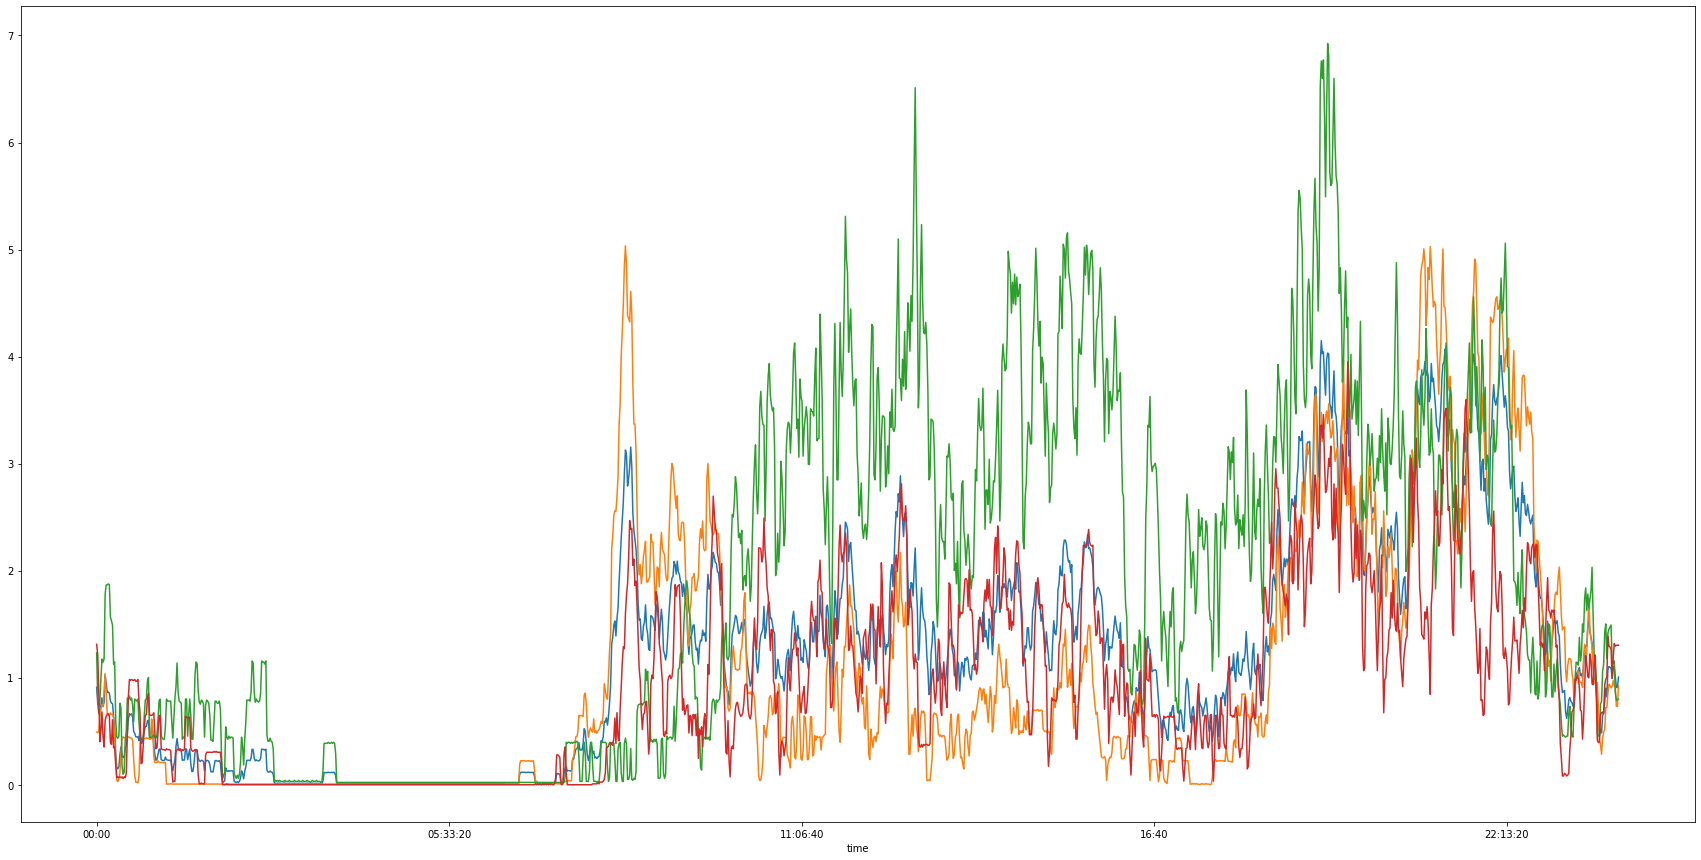

In [103]:
from vacances_scolaires_france import SchoolHolidayDates
import datetime
curves = ["Sub metering 1 during a day","Sub metering 1 during a business day","Sub metering 1 during the weekend","Sub metering 1 during a vacation day"]
d = SchoolHolidayDates()
dict_holidays = d.holidays_for_year_and_zone(2007, 'C')
holidays = dict_holidays.keys()

plt.figure(figsize=(30, 15))

sub1_df = df[['Sub_metering_1']]
sub1_df = sub1_df.reset_index()

sub1_df_all = sub1_df.loc[sub1_df["DateTime"].dt.year == 2007]
sub1_df_all.set_index('DateTime', inplace=True)
sub1_df_all = sub1_df_all.groupby([sub1_df_all.index.hour, sub1_df_all.index.minute]).mean()
sub1_df_all.set_index(pd.date_range("00:00","23:59", freq="1min").time,inplace=True)
plt.plot(sub1_df_all)

sub1_df_bd = sub1_df.loc[(sub1_df["DateTime"].dt.year == 2007) & (sub1_df["DateTime"].dt.weekday != 5) & (sub1_df["DateTime"].dt.weekday != 6) & (sub1_df["DateTime"].dt.date.isin(holidays)==False)]
sub1_df_bd.set_index('DateTime', inplace=True)
sub1_df_bd = sub1_df_bd.groupby([sub1_df_bd.index.hour, sub1_df_bd.index.minute]).mean()
sub1_df_bd.set_index(pd.date_range("00:00","23:59", freq="1min").time,inplace=True)
plt.plot(sub1_df_bd)

sub1_df_we = sub1_df.loc[(sub1_df["DateTime"].dt.year == 2007) & (sub1_df["DateTime"].dt.weekday.isin([5,6]))]
sub1_df_we.set_index('DateTime', inplace=True)
sub1_df_we = sub1_df_we.groupby([sub1_df_we.index.hour, sub1_df_we.index.minute]).mean()
sub1_df_we.set_index(pd.date_range("00:00","23:59", freq="1min").time,inplace=True)
plt.plot(sub1_df_we)

sub1_df_hd = sub1_df.loc[(sub1_df["DateTime"].dt.year == 2007) & (sub1_df["DateTime"].dt.date.isin(holidays))]
sub1_df_hd.set_index('DateTime', inplace=True)
sub1_df_hd = sub1_df_hd.groupby([sub1_df_hd.index.hour, sub1_df_hd.index.minute]).mean()
sub1_df_hd.set_index(pd.date_range("00:00","23:59", freq="1min").time,inplace=True)
plt.plot(sub1_df_hd)


plt.show()

### Sub metering 2 per hour of the day

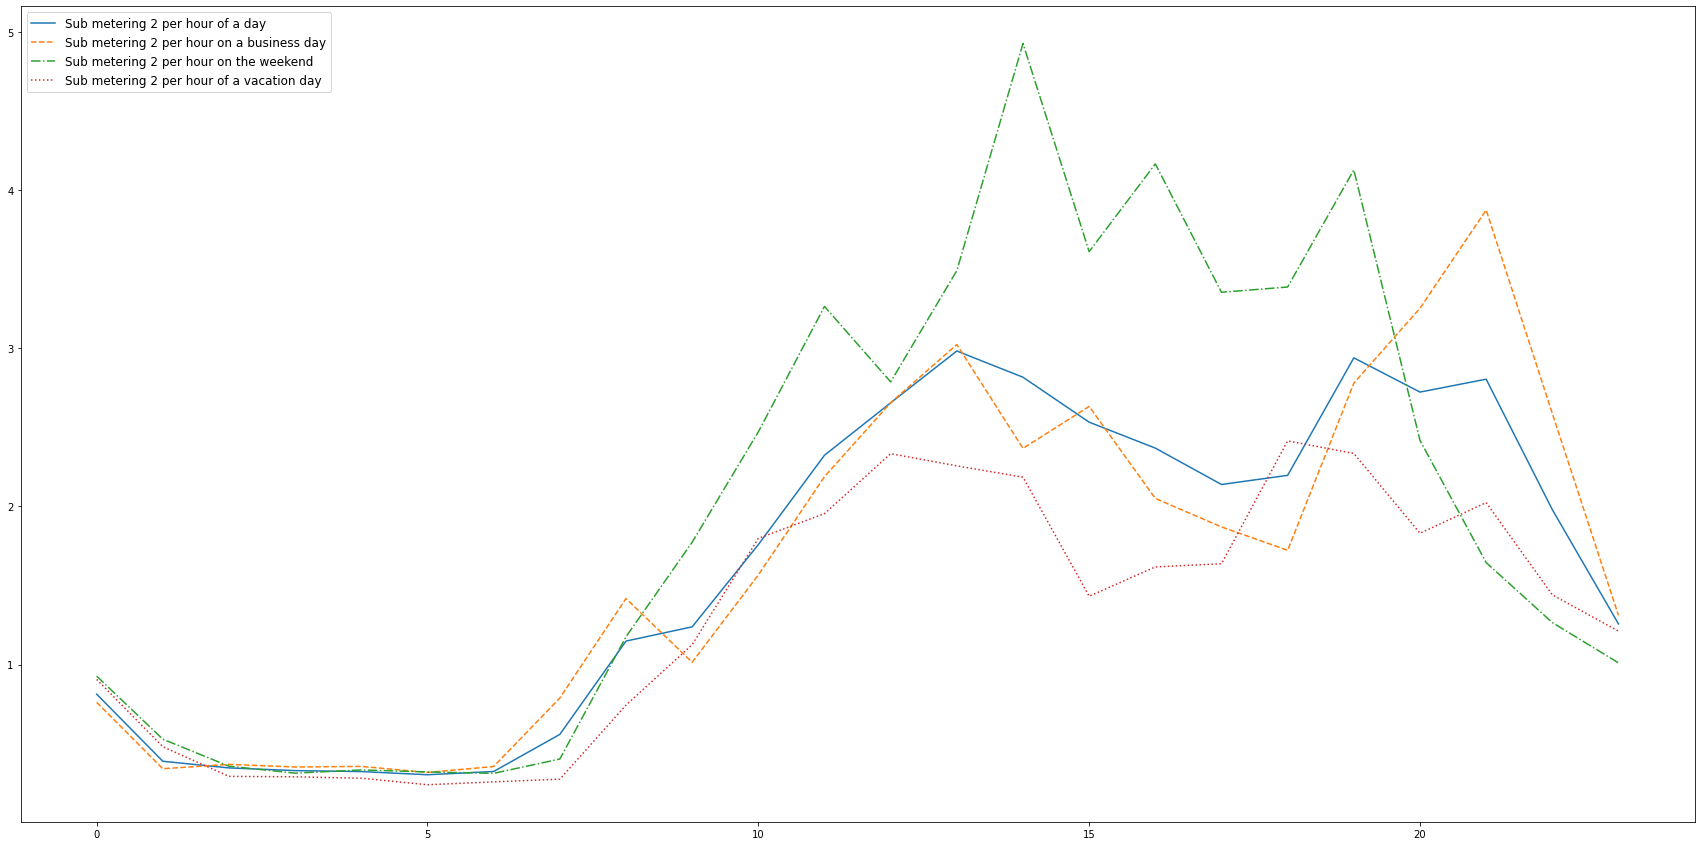

In [127]:
from vacances_scolaires_france import SchoolHolidayDates
import datetime
curves = ["Sub metering 2 per hour of a day","Sub metering 2 per hour on a business day","Sub metering 2 per hour on the weekend","Sub metering 2 per hour of a vacation day"]
d = SchoolHolidayDates()
dict_holidays = d.holidays_for_year_and_zone(2007, 'C')
holidays = dict_holidays.keys()

plt.figure(figsize=(30, 15))

sub2_df = df[['Sub_metering_2']]
sub2_df = sub2_df.reset_index()

sub2_df_all = sub2_df.loc[sub2_df["DateTime"].dt.year == 2007]
sub2_df_all.set_index('DateTime', inplace=True)
plt.plot(sub2_df_all.groupby(sub2_df_all.index.hour)["Sub_metering_2"].mean(),linestyle='-')

sub2_df_bd = sub2_df.loc[(sub2_df["DateTime"].dt.year == 2007) & (sub2_df["DateTime"].dt.weekday != 5) & (sub2_df["DateTime"].dt.weekday != 6) & (sub2_df["DateTime"].dt.date.isin(holidays)==False)]
sub2_df_bd.set_index('DateTime', inplace=True)
plt.plot(sub2_df_bd.groupby(sub2_df_bd.index.hour)["Sub_metering_2"].mean(),linestyle='--')

sub2_df_we = sub2_df.loc[(sub2_df["DateTime"].dt.year == 2007) & (sub2_df["DateTime"].dt.weekday.isin([5,6]))]
sub2_df_we.set_index('DateTime', inplace=True)
plt.plot(sub2_df_we.groupby(sub2_df_we.index.hour)["Sub_metering_2"].mean(),linestyle='-.')

sub2_df_hd = sub2_df.loc[(sub2_df["DateTime"].dt.year == 2007) & (sub2_df["DateTime"].dt.date.isin(holidays))]
sub2_df_hd.set_index('DateTime', inplace=True)
plt.plot(sub2_df_hd.groupby(sub2_df_hd.index.hour)["Sub_metering_2"].mean(),linestyle=':')

plt.legend(curves,loc=2,fontsize="large")

plt.show()

# add curves

### Sub metering 2 per minute of the day

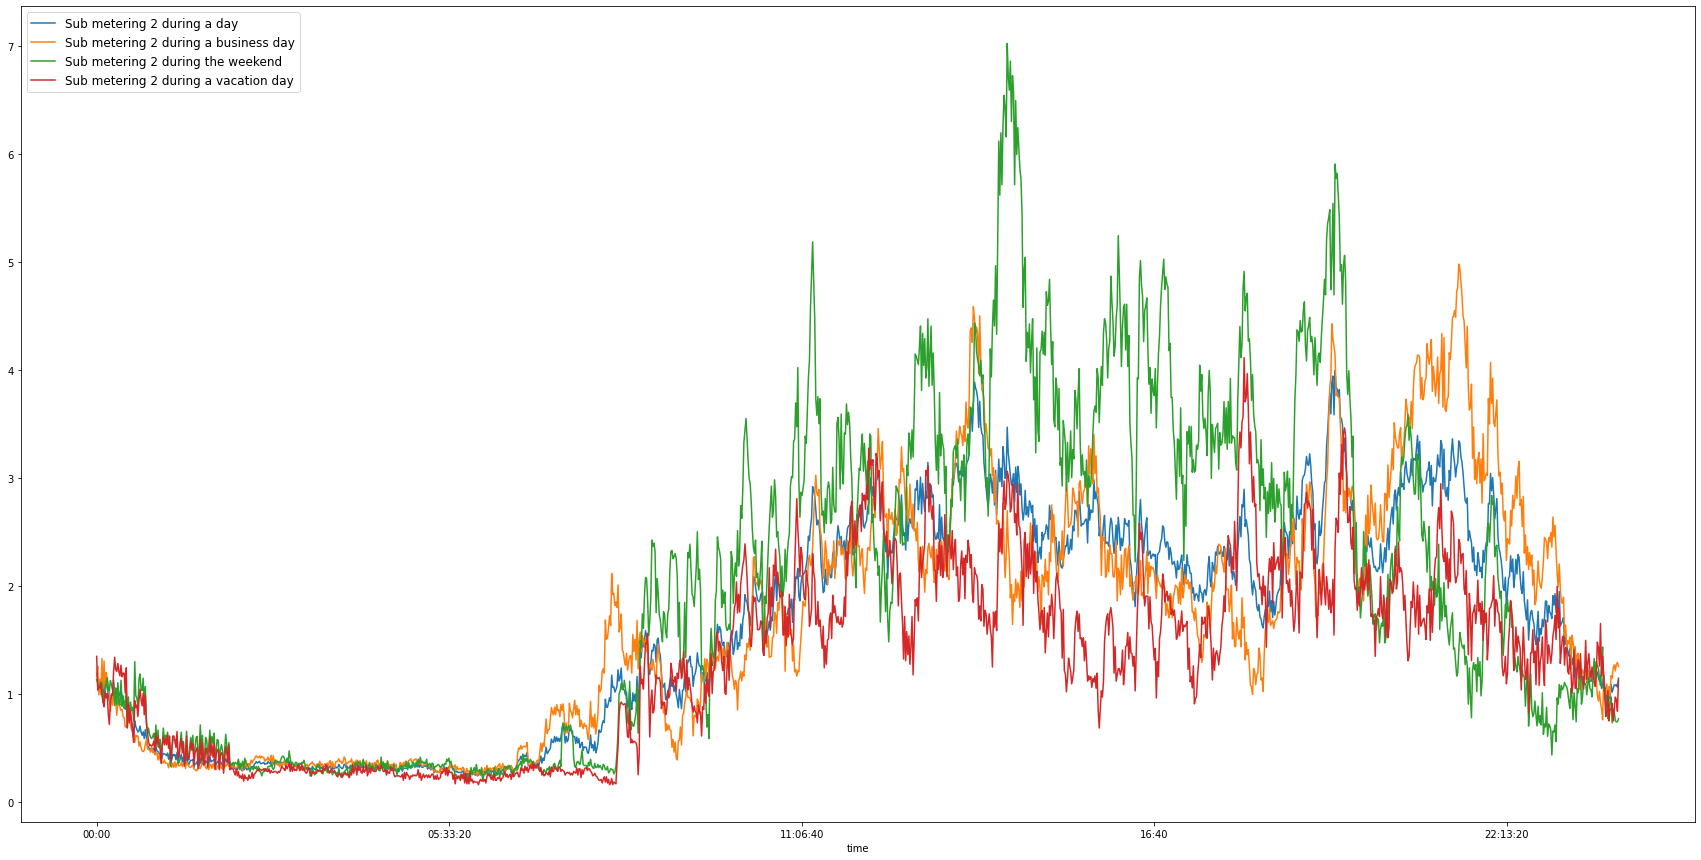

In [126]:
from vacances_scolaires_france import SchoolHolidayDates
import datetime
curves = ["Sub metering 2 during a day","Sub metering 2 during a business day","Sub metering 2 during the weekend","Sub metering 2 during a vacation day"]
d = SchoolHolidayDates()
dict_holidays = d.holidays_for_year_and_zone(2007, 'C')
holidays = dict_holidays.keys()

plt.figure(figsize=(30, 15))

sub2_df = df[['Sub_metering_2']]
sub2_df = sub2_df.reset_index()

sub2_df_all = sub2_df.loc[sub2_df["DateTime"].dt.year == 2007]
sub2_df_all.set_index('DateTime', inplace=True)
sub2_df_all = sub2_df_all.groupby([sub2_df_all.index.hour, sub2_df_all.index.minute]).mean()
sub2_df_all.set_index(pd.date_range("00:00","23:59", freq="1min").time,inplace=True)
plt.plot(sub2_df_all)

sub2_df_bd = sub2_df.loc[(sub2_df["DateTime"].dt.year == 2007) & (sub2_df["DateTime"].dt.weekday != 5) & (sub2_df["DateTime"].dt.weekday != 6) & (sub2_df["DateTime"].dt.date.isin(holidays)==False)]
sub2_df_bd.set_index('DateTime', inplace=True)
sub2_df_bd = sub2_df_bd.groupby([sub2_df_bd.index.hour, sub2_df_bd.index.minute]).mean()
sub2_df_bd.set_index(pd.date_range("00:00","23:59", freq="1min").time,inplace=True)
plt.plot(sub2_df_bd)

sub2_df_we = sub2_df.loc[(sub2_df["DateTime"].dt.year == 2007) & (sub2_df["DateTime"].dt.weekday.isin([5,6]))]
sub2_df_we.set_index('DateTime', inplace=True)
sub2_df_we = sub2_df_we.groupby([sub2_df_we.index.hour, sub2_df_we.index.minute]).mean()
sub2_df_we.set_index(pd.date_range("00:00","23:59", freq="1min").time,inplace=True)
plt.plot(sub2_df_we)

sub2_df_hd = sub2_df.loc[(sub2_df["DateTime"].dt.year == 2007) & (sub2_df["DateTime"].dt.date.isin(holidays))]
sub2_df_hd.set_index('DateTime', inplace=True)
sub2_df_hd = sub2_df_hd.groupby([sub2_df_hd.index.hour, sub2_df_hd.index.minute]).mean()
sub2_df_hd.set_index(pd.date_range("00:00","23:59", freq="1min").time,inplace=True)
plt.plot(sub2_df_hd)

plt.legend(curves,loc=2,fontsize="large")

plt.show()

### Sub metering 3 per hour of the day

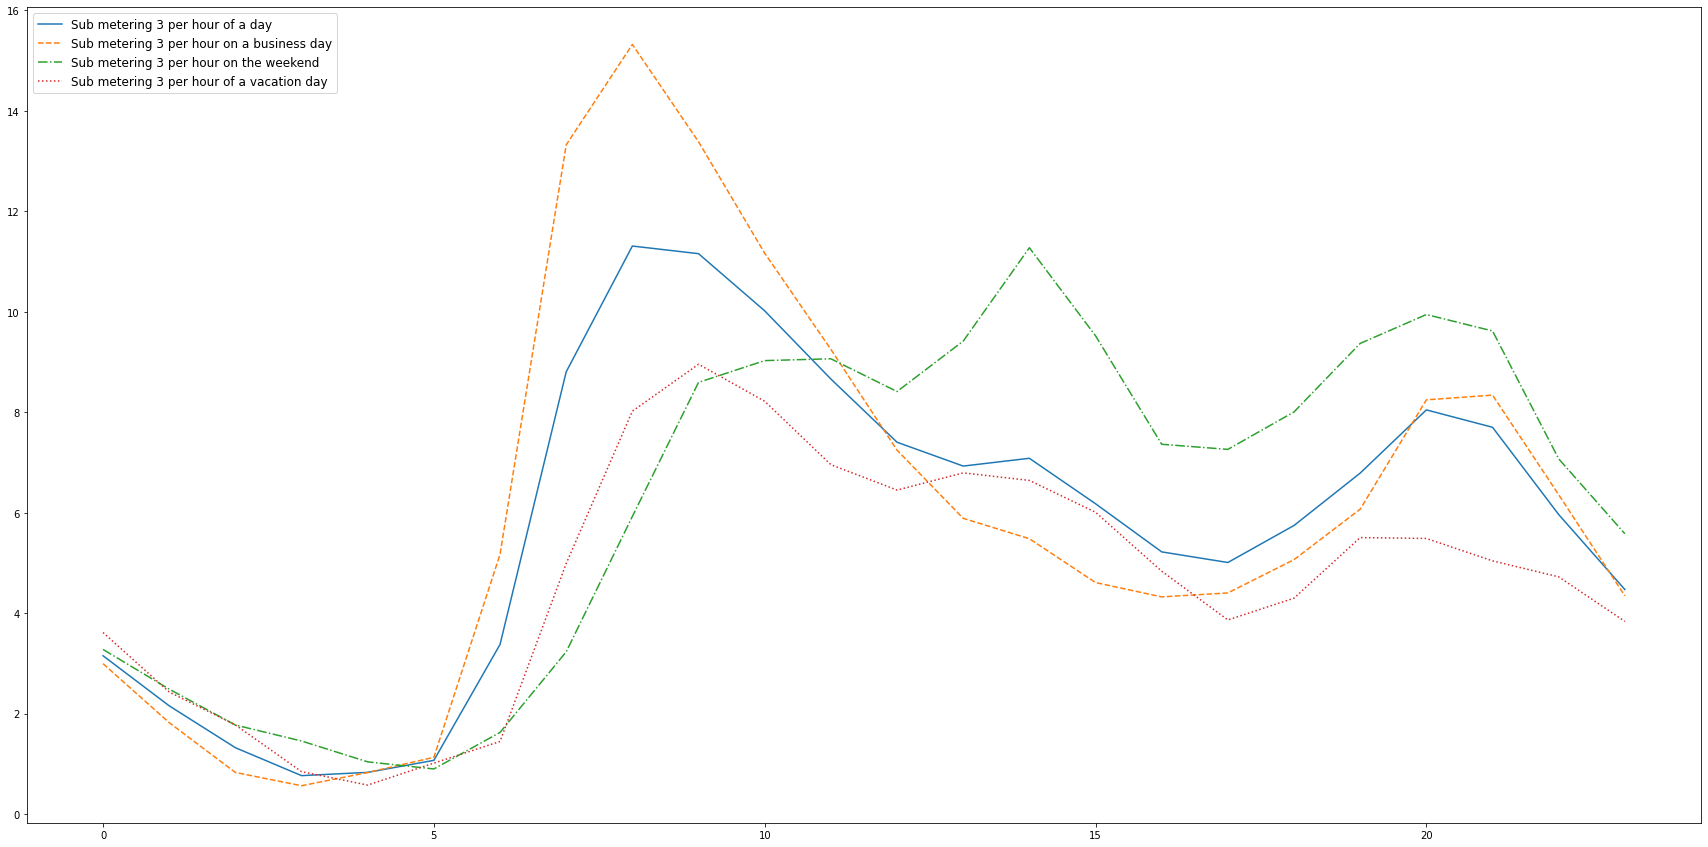

In [128]:
from vacances_scolaires_france import SchoolHolidayDates
import datetime
curves = ["Sub metering 3 per hour of a day","Sub metering 3 per hour on a business day","Sub metering 3 per hour on the weekend","Sub metering 3 per hour of a vacation day"]
d = SchoolHolidayDates()
dict_holidays = d.holidays_for_year_and_zone(2007, 'C')
holidays = dict_holidays.keys()

plt.figure(figsize=(30, 15))

sub3_df = df[['Sub_metering_3']]
sub3_df = sub3_df.reset_index()

sub3_df_all = sub3_df.loc[sub3_df["DateTime"].dt.year == 2007]
sub3_df_all.set_index('DateTime', inplace=True)
plt.plot(sub3_df_all.groupby(sub3_df_all.index.hour)["Sub_metering_3"].mean(),linestyle='-')

sub3_df_bd = sub3_df.loc[(sub3_df["DateTime"].dt.year == 2007) & (sub3_df["DateTime"].dt.weekday != 5) & (sub3_df["DateTime"].dt.weekday != 6) & (sub3_df["DateTime"].dt.date.isin(holidays)==False)]
sub3_df_bd.set_index('DateTime', inplace=True)
plt.plot(sub3_df_bd.groupby(sub3_df_bd.index.hour)["Sub_metering_3"].mean(),linestyle='--')

sub3_df_we = sub3_df.loc[(sub3_df["DateTime"].dt.year == 2007) & (sub3_df["DateTime"].dt.weekday.isin([5,6]))]
sub3_df_we.set_index('DateTime', inplace=True)
plt.plot(sub3_df_we.groupby(sub3_df_we.index.hour)["Sub_metering_3"].mean(),linestyle='-.')

sub3_df_hd = sub3_df.loc[(sub3_df["DateTime"].dt.year == 2007) & (sub3_df["DateTime"].dt.date.isin(holidays))]
sub3_df_hd.set_index('DateTime', inplace=True)
plt.plot(sub3_df_hd.groupby(sub3_df_hd.index.hour)["Sub_metering_3"].mean(),linestyle=':')

plt.legend(curves,loc=2,fontsize="large")

plt.show()

# add curves

### Sub metering 3 per minute of the day

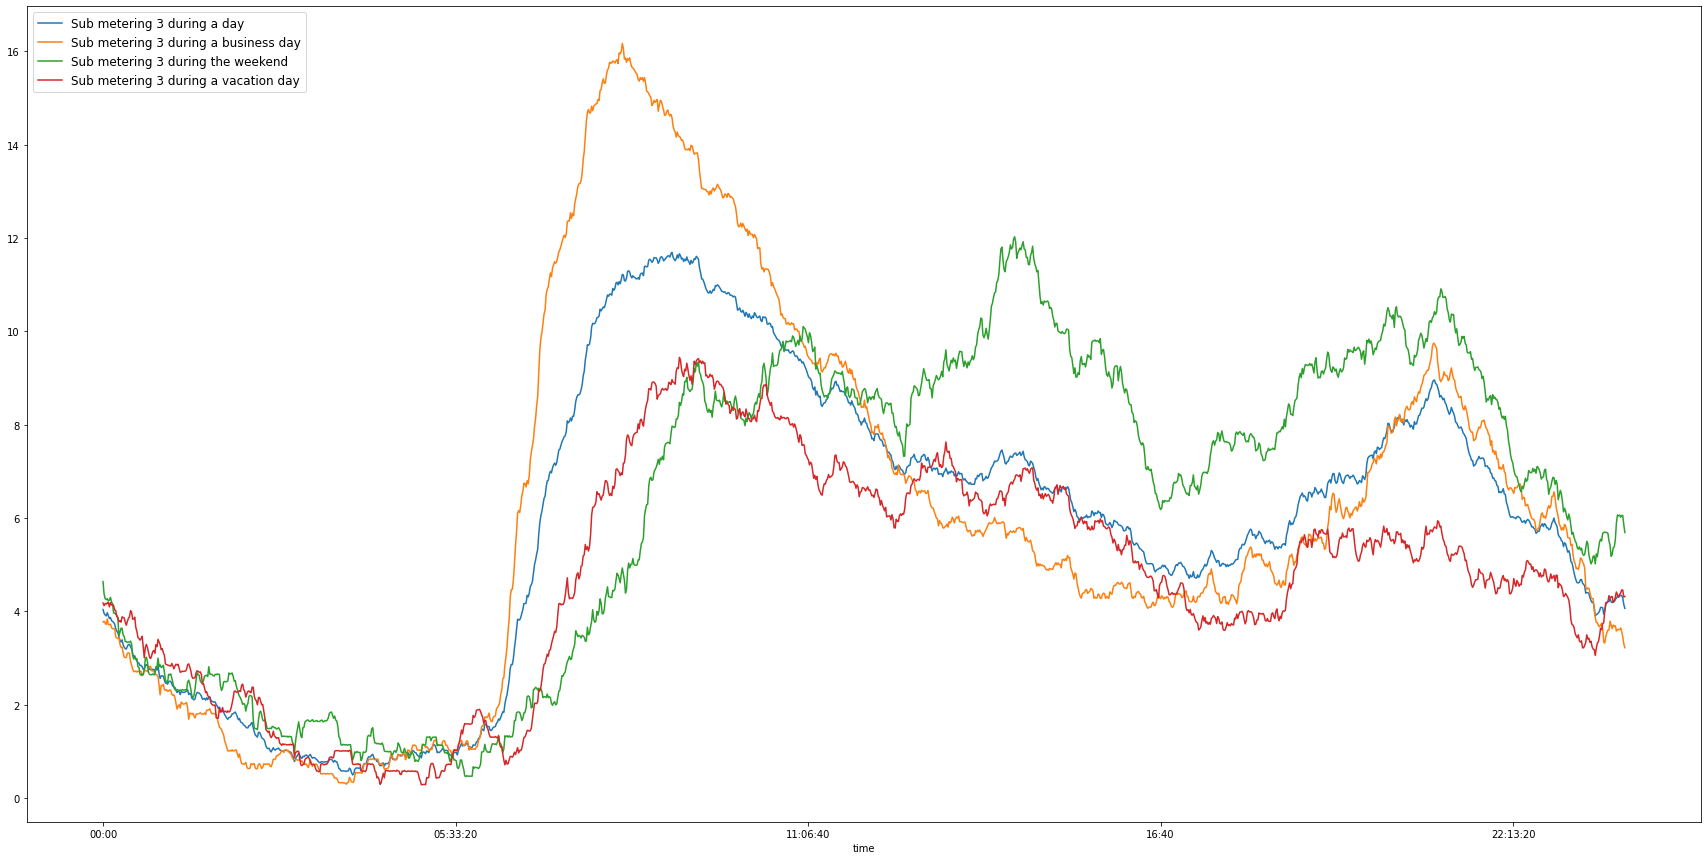

In [129]:
from vacances_scolaires_france import SchoolHolidayDates
import datetime
curves = ["Sub metering 3 during a day","Sub metering 3 during a business day","Sub metering 3 during the weekend","Sub metering 3 during a vacation day"]
d = SchoolHolidayDates()
dict_holidays = d.holidays_for_year_and_zone(2007, 'C')
holidays = dict_holidays.keys()

plt.figure(figsize=(30, 15))

sub3_df = df[['Sub_metering_3']]
sub3_df = sub3_df.reset_index()

sub3_df_all = sub3_df.loc[sub3_df["DateTime"].dt.year == 2007]
sub3_df_all.set_index('DateTime', inplace=True)
sub3_df_all = sub3_df_all.groupby([sub3_df_all.index.hour, sub3_df_all.index.minute]).mean()
sub3_df_all.set_index(pd.date_range("00:00","23:59", freq="1min").time,inplace=True)
plt.plot(sub3_df_all)

sub3_df_bd = sub3_df.loc[(sub3_df["DateTime"].dt.year == 2007) & (sub3_df["DateTime"].dt.weekday != 5) & (sub3_df["DateTime"].dt.weekday != 6) & (sub3_df["DateTime"].dt.date.isin(holidays)==False)]
sub3_df_bd.set_index('DateTime', inplace=True)
sub3_df_bd = sub3_df_bd.groupby([sub3_df_bd.index.hour, sub3_df_bd.index.minute]).mean()
sub3_df_bd.set_index(pd.date_range("00:00","23:59", freq="1min").time,inplace=True)
plt.plot(sub3_df_bd)

sub3_df_we = sub3_df.loc[(sub3_df["DateTime"].dt.year == 2007) & (sub3_df["DateTime"].dt.weekday.isin([5,6]))]
sub3_df_we.set_index('DateTime', inplace=True)
sub3_df_we = sub3_df_we.groupby([sub3_df_we.index.hour, sub3_df_we.index.minute]).mean()
sub3_df_we.set_index(pd.date_range("00:00","23:59", freq="1min").time,inplace=True)
plt.plot(sub3_df_we)

sub3_df_hd = sub3_df.loc[(sub3_df["DateTime"].dt.year == 2007) & (sub3_df["DateTime"].dt.date.isin(holidays))]
sub3_df_hd.set_index('DateTime', inplace=True)
sub3_df_hd = sub3_df_hd.groupby([sub3_df_hd.index.hour, sub3_df_hd.index.minute]).mean()
sub3_df_hd.set_index(pd.date_range("00:00","23:59", freq="1min").time,inplace=True)
plt.plot(sub3_df_hd)

plt.legend(curves,loc=2,fontsize="large")

plt.show()

# add curves

## Focus on smaller time periods : finding patterns and habits

### Sub metering 1 per minute between 6AM and 9AM

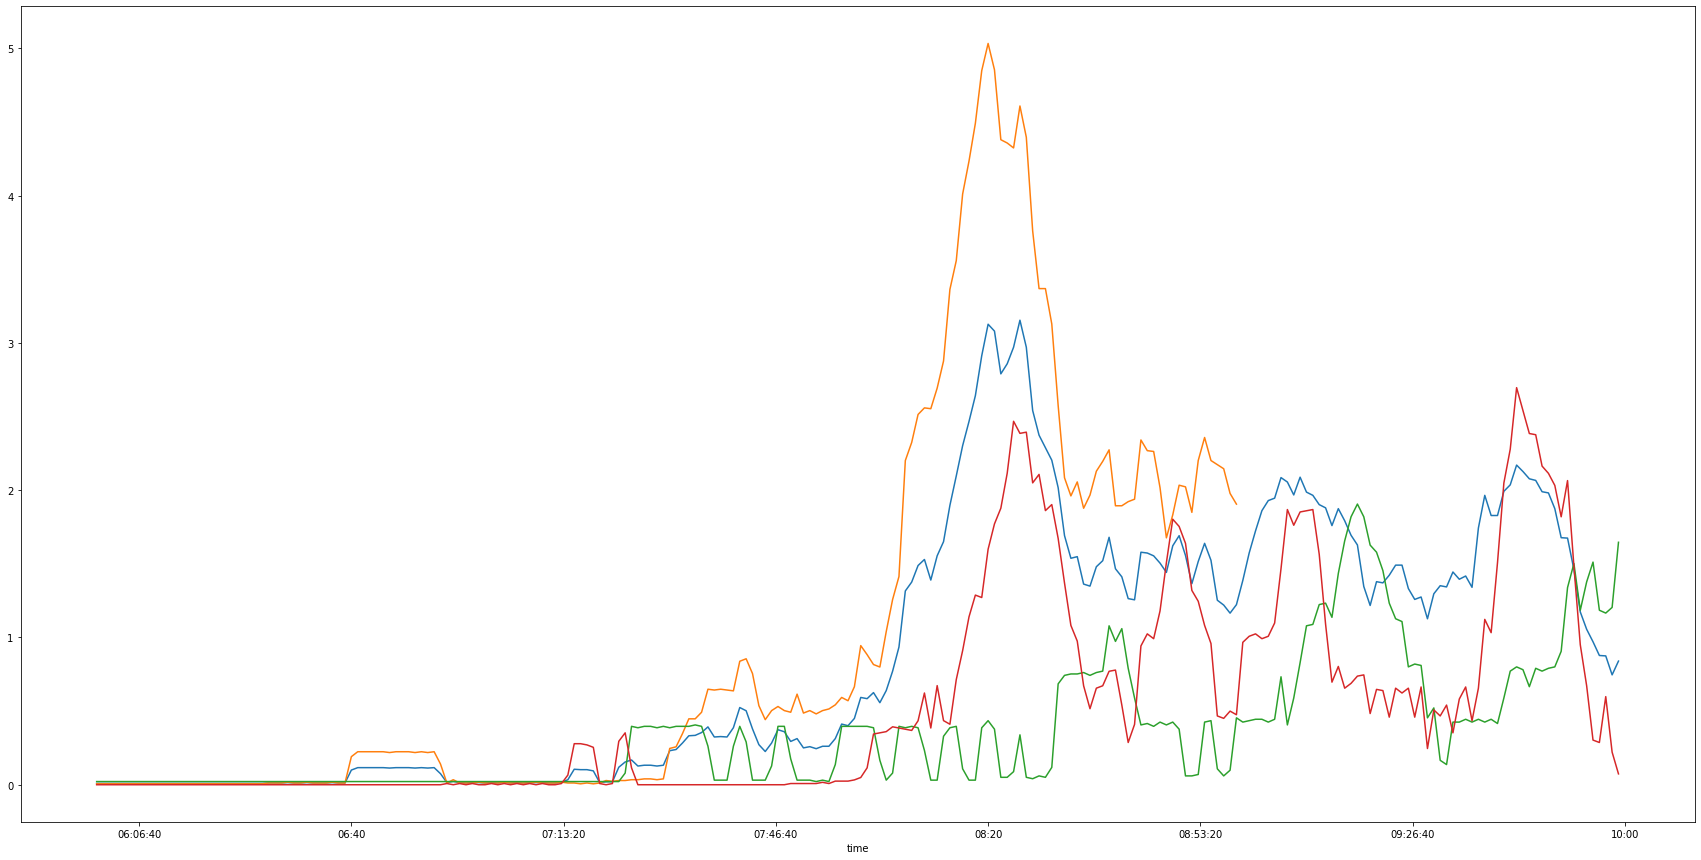

In [131]:
from vacances_scolaires_france import SchoolHolidayDates
import datetime
curves = ["Sub metering 1 during a day","Sub metering 1 during a business day","Sub metering 1 during the weekend","Sub metering 1 during a vacation day"]
d = SchoolHolidayDates()
dict_holidays = d.holidays_for_year_and_zone(2007, 'C')
holidays = dict_holidays.keys()

plt.figure(figsize=(30, 15))

sub1_df = df[['Sub_metering_1']]
sub1_df = sub1_df.reset_index()

sub1_df_all = sub1_df.loc[sub1_df["DateTime"].dt.year == 2007]
sub1_df_all.set_index('DateTime', inplace=True)
sub1_df_all = sub1_df_all.groupby([sub1_df_all.index.hour, sub1_df_all.index.minute]).mean()
sub1_df_all.set_index(pd.date_range("00:00","23:59", freq="1min").time,inplace=True)

plt.plot(sub1_df_all[360:600])

sub1_df_bd = sub1_df.loc[(sub1_df["DateTime"].dt.year == 2007) & (sub1_df["DateTime"].dt.weekday != 5) & (sub1_df["DateTime"].dt.weekday != 6) & (sub1_df["DateTime"].dt.date.isin(holidays)==False)]
sub1_df_bd.set_index('DateTime', inplace=True)
sub1_df_bd = sub1_df_bd.groupby([sub1_df_bd.index.hour, sub1_df_bd.index.minute]).mean()
sub1_df_bd.set_index(pd.date_range("00:00","23:59", freq="1min").time,inplace=True)
plt.plot(sub1_df_bd[360:540])

sub1_df_we = sub1_df.loc[(sub1_df["DateTime"].dt.year == 2007) & (sub1_df["DateTime"].dt.weekday.isin([5,6]))]
sub1_df_we.set_index('DateTime', inplace=True)
sub1_df_we = sub1_df_we.groupby([sub1_df_we.index.hour, sub1_df_we.index.minute]).mean()
sub1_df_we.set_index(pd.date_range("00:00","23:59", freq="1min").time,inplace=True)
plt.plot(sub1_df_we[360:600])

sub1_df_hd = sub1_df.loc[(sub1_df["DateTime"].dt.year == 2007) & (sub1_df["DateTime"].dt.date.isin(holidays))]
sub1_df_hd.set_index('DateTime', inplace=True)
sub1_df_hd = sub1_df_hd.groupby([sub1_df_hd.index.hour, sub1_df_hd.index.minute]).mean()
sub1_df_hd.set_index(pd.date_range("00:00","23:59", freq="1min").time,inplace=True)
plt.plot(sub1_df_hd[360:600])


plt.show()

### Sub metering 2 per minute between 6AM and 9AM

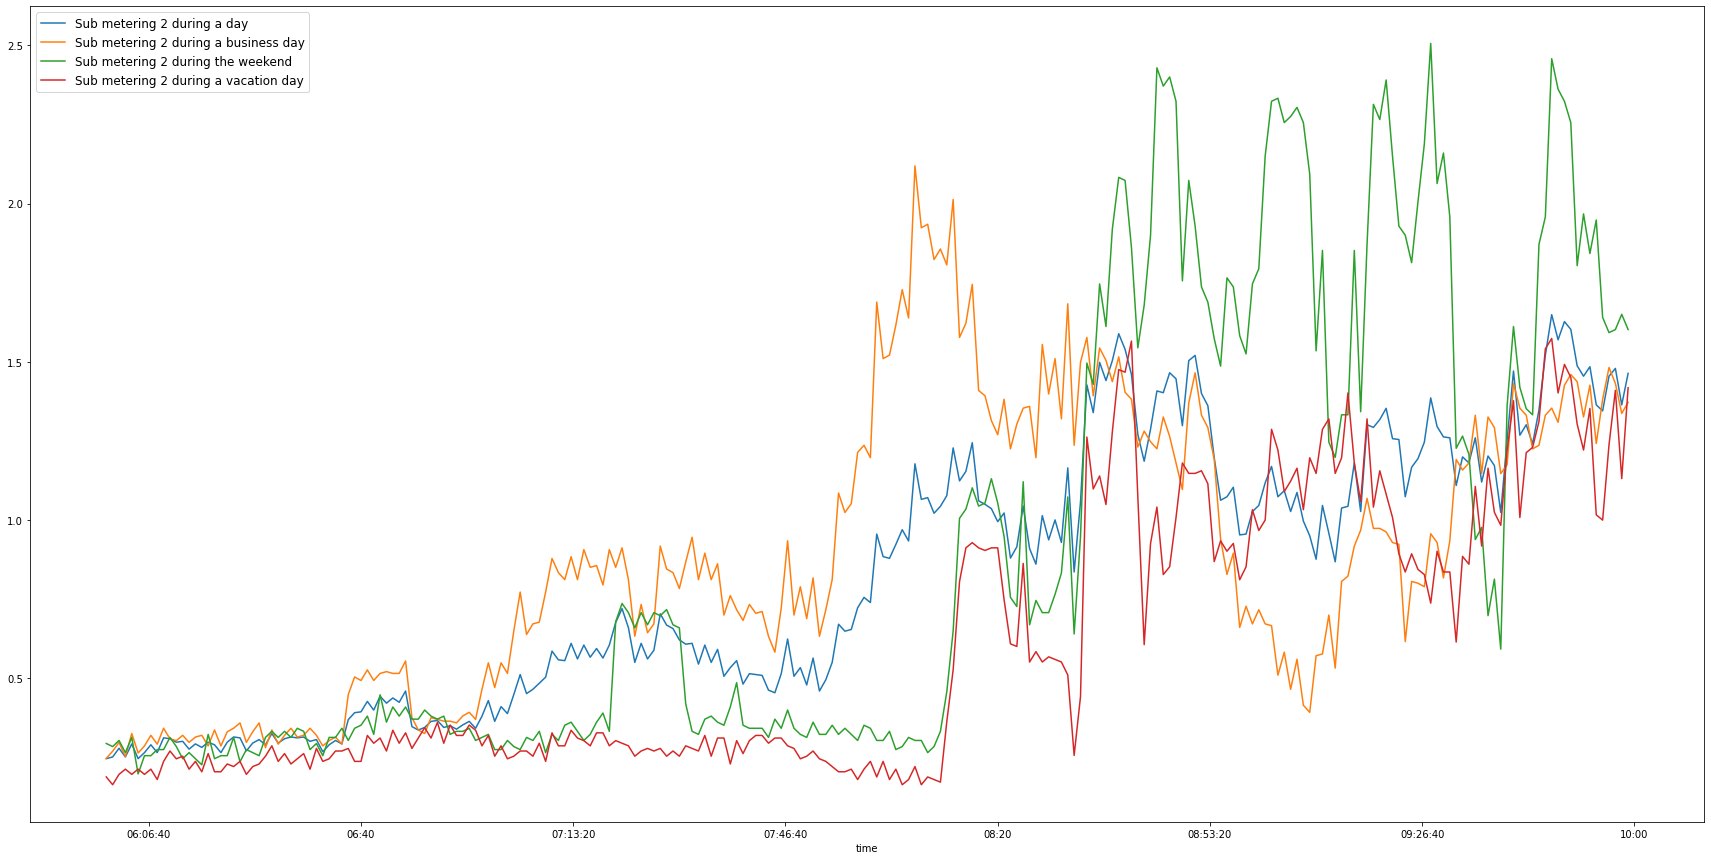

In [130]:
from vacances_scolaires_france import SchoolHolidayDates
import datetime
curves = ["Sub metering 2 during a day","Sub metering 2 during a business day","Sub metering 2 during the weekend","Sub metering 2 during a vacation day"]
d = SchoolHolidayDates()
dict_holidays = d.holidays_for_year_and_zone(2007, 'C')
holidays = dict_holidays.keys()

plt.figure(figsize=(30, 15))

sub2_df = df[['Sub_metering_2']]
sub2_df = sub2_df.reset_index()

sub2_df_all = sub2_df.loc[sub2_df["DateTime"].dt.year == 2007]
sub2_df_all.set_index('DateTime', inplace=True)
sub2_df_all = sub2_df_all.groupby([sub2_df_all.index.hour, sub2_df_all.index.minute]).mean()
sub2_df_all.set_index(pd.date_range("00:00","23:59", freq="1min").time,inplace=True)
plt.plot(sub2_df_all[360:600])

sub2_df_bd = sub2_df.loc[(sub2_df["DateTime"].dt.year == 2007) & (sub2_df["DateTime"].dt.weekday != 5) & (sub2_df["DateTime"].dt.weekday != 6) & (sub2_df["DateTime"].dt.date.isin(holidays)==False)]
sub2_df_bd.set_index('DateTime', inplace=True)
sub2_df_bd = sub2_df_bd.groupby([sub2_df_bd.index.hour, sub2_df_bd.index.minute]).mean()
sub2_df_bd.set_index(pd.date_range("00:00","23:59", freq="1min").time,inplace=True)
plt.plot(sub2_df_bd[360:600])

sub2_df_we = sub2_df.loc[(sub2_df["DateTime"].dt.year == 2007) & (sub2_df["DateTime"].dt.weekday.isin([5,6]))]
sub2_df_we.set_index('DateTime', inplace=True)
sub2_df_we = sub2_df_we.groupby([sub2_df_we.index.hour, sub2_df_we.index.minute]).mean()
sub2_df_we.set_index(pd.date_range("00:00","23:59", freq="1min").time,inplace=True)
plt.plot(sub2_df_we[360:600])

sub2_df_hd = sub2_df.loc[(sub2_df["DateTime"].dt.year == 2007) & (sub2_df["DateTime"].dt.date.isin(holidays))]
sub2_df_hd.set_index('DateTime', inplace=True)
sub2_df_hd = sub2_df_hd.groupby([sub2_df_hd.index.hour, sub2_df_hd.index.minute]).mean()
sub2_df_hd.set_index(pd.date_range("00:00","23:59", freq="1min").time,inplace=True)
plt.plot(sub2_df_hd[360:600])

plt.legend(curves,loc=2,fontsize="large")

plt.show()

### Sub metering 3 per minute between 6AM and 9AM

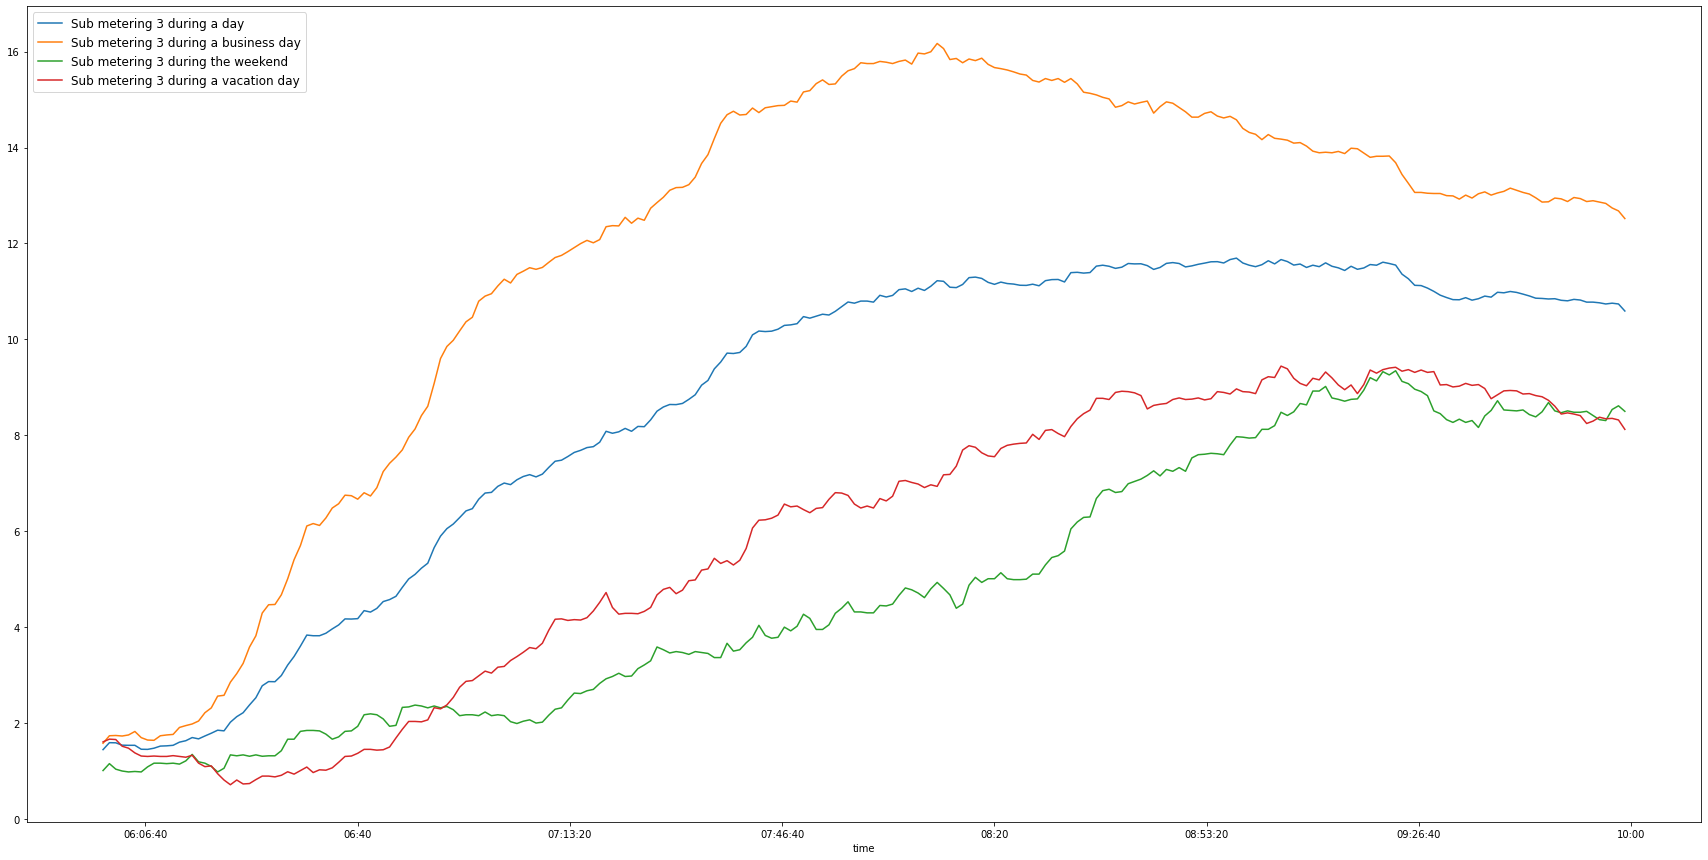

In [132]:
from vacances_scolaires_france import SchoolHolidayDates
import datetime
curves = ["Sub metering 3 during a day","Sub metering 3 during a business day","Sub metering 3 during the weekend","Sub metering 3 during a vacation day"]
d = SchoolHolidayDates()
dict_holidays = d.holidays_for_year_and_zone(2007, 'C')
holidays = dict_holidays.keys()

plt.figure(figsize=(30, 15))

sub3_df = df[['Sub_metering_3']]
sub3_df = sub3_df.reset_index()

sub3_df_all = sub3_df.loc[sub3_df["DateTime"].dt.year == 2007]
sub3_df_all.set_index('DateTime', inplace=True)
sub3_df_all = sub3_df_all.groupby([sub3_df_all.index.hour, sub3_df_all.index.minute]).mean()
sub3_df_all.set_index(pd.date_range("00:00","23:59", freq="1min").time,inplace=True)
plt.plot(sub3_df_all[360:600])

sub3_df_bd = sub3_df.loc[(sub3_df["DateTime"].dt.year == 2007) & (sub3_df["DateTime"].dt.weekday != 5) & (sub3_df["DateTime"].dt.weekday != 6) & (sub3_df["DateTime"].dt.date.isin(holidays)==False)]
sub3_df_bd.set_index('DateTime', inplace=True)
sub3_df_bd = sub3_df_bd.groupby([sub3_df_bd.index.hour, sub3_df_bd.index.minute]).mean()
sub3_df_bd.set_index(pd.date_range("00:00","23:59", freq="1min").time,inplace=True)
plt.plot(sub3_df_bd[360:600])

sub3_df_we = sub3_df.loc[(sub3_df["DateTime"].dt.year == 2007) & (sub3_df["DateTime"].dt.weekday.isin([5,6]))]
sub3_df_we.set_index('DateTime', inplace=True)
sub3_df_we = sub3_df_we.groupby([sub3_df_we.index.hour, sub3_df_we.index.minute]).mean()
sub3_df_we.set_index(pd.date_range("00:00","23:59", freq="1min").time,inplace=True)
plt.plot(sub3_df_we[360:600])

sub3_df_hd = sub3_df.loc[(sub3_df["DateTime"].dt.year == 2007) & (sub3_df["DateTime"].dt.date.isin(holidays))]
sub3_df_hd.set_index('DateTime', inplace=True)
sub3_df_hd = sub3_df_hd.groupby([sub3_df_hd.index.hour, sub3_df_hd.index.minute]).mean()
sub3_df_hd.set_index(pd.date_range("00:00","23:59", freq="1min").time,inplace=True)
plt.plot(sub3_df_hd[360:600])

plt.legend(curves,loc=2,fontsize="large")

plt.show()

# add curves

#### Sub metering 1 per hour of the weekend days

## Additional Variable : Temperatures (min, max and average)

In [ ]:
x = (daily_avg['max_temp']+daily_avg['min_temp'])/2
y = daily_avg['Global_active_power']

m, b = np.polyfit(x, y, 1)
print('Global electic consumption = {}*x + {}'.format(m,b)) 

plt.plot(x,y, linestyle='None',marker='o')
plt.plot(x, m*x+b)

In [ ]:
x = (daily_avg['max_temp']+daily_avg['min_temp'])/2
y = (daily_avg['Global_active_power']*1000/60)-daily_avg['Sub_metering_1']-daily_avg['Sub_metering_2']-daily_avg['Sub_metering_3']

m, b = np.polyfit(x, y, 1)
print('active energy of non measured electic devices = {}*x + {}'.format(m,b)) 

plt.plot(x,y, linestyle='None',marker='o')
plt.plot(x, m*x+b)

In [ ]:
x = (daily_avg['max_temp']+daily_avg['min_temp'])/2
y = (daily_avg['Global_active_power']*1000/60)-daily_avg['Sub_metering_1']-daily_avg['Sub_metering_2']

m, b = np.polyfit(x, y, 1)
print('active energy of non measured electic devices + sub3= {}*x + {}'.format(m,b)) 

plt.plot(x,y, linestyle='None',marker='o')
plt.plot(x, m*x+b)

In [ ]:
def subplot_coord(x,y,param="all"):
    tuples =[]
    if param=="all":
        for i in range(x+1):
            for j in range(y+1):
                tuples.append((i,j))
    elif param=="line":
        for j in range(y+1):
                tuples.append((x,j))
    elif param=="line":
        for i in range(x+1):
                tuples.append((i,y))
    return tuples  

In [ ]:
fig, axis = plt.subplots(2,4,figsize=(20, 10))
fig.delaxes(axis[1,3])
indexes = [(0,0),(0,1),(0,2),(0,3),(1,0),(1,1),(1,2)]
variables = list(df.columns)
variables.remove('DateTime')
data_bd = df.loc[(df["DateTime"].dt.weekday != 5) & (df["DateTime"].dt.weekday !=6) & (df["DateTime"].dt.date.isin(holidays)==False)]
data_we = df.loc[(df["DateTime"].dt.weekday == 5) | (df["DateTime"].dt.weekday ==6)]
data_hd = df.loc[(df["DateTime"].dt.date.isin(holidays))]


for idx, val in enumerate(indexes):
    temp_bd=data_bd[['DateTime',variables[idx]]]
    temp_we=data_we[['DateTime',variables[idx]]]
    temp_hd=data_hd[['DateTime',variables[idx]]]
    axis[val[0],val[1]].plot(temp_bd.groupby(temp_bd['DateTime'].dt.hour)[variables[idx]].mean())
    axis[val[0],val[1]].plot(temp_we.groupby(temp_we['DateTime'].dt.hour)[variables[idx]].mean())
    axis[val[0],val[1]].plot(temp_hd.groupby(temp_hd['DateTime'].dt.hour)[variables[idx]].mean())
    axis[val[0],val[1]].set_title(variables[idx])
        
fig.tight_layout(pad=3.0)
fig.legend(['Business days', 'Weekends', 'Holidays'],loc=4, bbox_to_anchor=(0.5, 0., 0.5, 0.5),fontsize="large")
fig.show()

In [ ]:
fig, axis = plt.subplots(24,7,figsize=(25, 72))

hour = 0
variables = list(df.columns)
variables.remove('DateTime')
data_bd = df.loc[(df["DateTime"].dt.weekday != 5) & (df["DateTime"].dt.weekday !=6) & (df["DateTime"].dt.date.isin(holidays)==False)]
data_we = df.loc[(df["DateTime"].dt.weekday == 5) | (df["DateTime"].dt.weekday ==6)]
data_hd = df.loc[(df["DateTime"].dt.date.isin(holidays))]

for i in range(24):
    indexes = subplot_coord(i,6,"line")
    for idx, val in enumerate(indexes):
        temp_bd=data_bd[['DateTime',variables[idx]]].loc[(data_bd["DateTime"].dt.hour ==i)]
        temp_we=data_we[['DateTime',variables[idx]]].loc[(data_we["DateTime"].dt.hour ==i)]
        temp_hd=data_hd[['DateTime',variables[idx]]].loc[(data_hd["DateTime"].dt.hour ==i)]
        axis[val[0],val[1]].plot(temp_bd.groupby(temp_bd['DateTime'].dt.minute)[variables[idx]].mean())
        axis[val[0],val[1]].plot(temp_we.groupby(temp_we['DateTime'].dt.minute)[variables[idx]].mean())
        axis[val[0],val[1]].plot(temp_hd.groupby(temp_hd['DateTime'].dt.minute)[variables[idx]].mean())
        if val[0]==0:
            axis[val[0],val[1]].set_title(variables[idx], fontsize=10)
        if val[1]==0:
            axis[val[0],val[1]].set_title("{0}h-{1}h:".format(i,i+1), loc="left", fontsize=12)

fig.tight_layout(pad=3.0)
fig.legend(['Business days', 'Weekends', 'Holidays'],loc=4, bbox_to_anchor=(0.5, 0., 0.5, 0.5),fontsize="large")
fig.show()